### This Lab Assignment is done by CS20B1044 Avinash R Changrani

In this lab assignment, you will be implementing the ResNet-152 model, a deep convolutional neural network, for classifying skin lesions from the ISIC 2018 dataset. Additionally, you will explore the effects of dilation on the performance of the ResNet-152 model for this task.

- Download the ISIC-2018 dataset and the Models from the link given at the end of the question.
- The images are already preprocessed, prepare the labels properly.
- First train the model without dilation and utilize optimization techniques such as regularization, early stopping, etc.
- Utilize the proper loss function.
- After training the model, evaluate the model’s performance on the test dataset.
- Calculate classification metrics such as accuracy, precision, recall, and F1-score.
- Now repeat the same steps for Dilated ResNet-152 and **compare the results for both in the form of a Table**.
- Further modifications can be done in the model to improve the results such as replacing the GlobalAveragePooling with a series of Dense layers, Changing the dilation rate, etc.


Dataset: [isic2018-10k-mv-384-jpg-stratified](https://www.kaggle.com/datasets/hitman1309/isic2018-10k-non-mv-384-jpg-stratified)

There are 7 classes in the dataset : 1. MEL : Melanoma, 2. NV : Melanocytic nevus, 3. BCC : Basal cell carcinoma, 4. AKIEC : Actinic keratosis / Bowen’s disease, 5. BKL : Benign keratosis, 6. DF : Dermatofibroma, 7. VASC : Vascular lesion.

The training csv file consists of 11 columns, image_id - unique id for every image;, 4. lesion_id - unique id for every lesion; diagnosis_confirm_type - gives more information regarding the diagnosis of the image (not to be used for classification) ; 7 columns each representing one class; fold_number : can be ignored.

In both the training and the testing csv files, there are 7 columns each representing one class as mentioned above, for each image these 7 columns represent the one hot representation of the class.


More information about the dataset can be found [here](https://challenge2018.isic-archive.com/)


In [2]:
# import the required libraries
import os
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
import seaborn as sns

In [4]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "/kaggle/input/models/ResNet18_without_Dilation.py", dst = "/kaggle/working/ResNet18_without_Dilation.py")

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "/kaggle/input/models/ResNet18_with_Dilation.py", dst = "/kaggle/working/ResNet18_with_Dilation.py")

'/kaggle/working/ResNet18_with_Dilation.py'

In [7]:
# import the models
from ResNet18_with_Dilation import ResNet18_With_Dilation
from ResNet18_without_Dilation import ResNet18_Without_Dilation

2024-04-14 16:31:40.494131: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 16:31:40.494241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 16:31:40.748384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
train_df = pd.read_csv('/kaggle/input/isic2018-10k-non-mv-384-jpg-stratified/ISIC2018_Task3_Training_LesionGroupings_WithoutDuplicates_Merged.csv')

train_df

,image,lesion_id,diagnosis_confirm_type,MEL,NV,BCC,AKIEC,BKL,DF,VASC,fold_number
0,ISIC_0024306,HAM_0000550,serial imaging showing no change,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
1,ISIC_0024307,HAM_0003577,serial imaging showing no change,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0
2,ISIC_0024308,HAM_0001477,serial imaging showing no change,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,ISIC_0024309,HAM_0000484,serial imaging showing no change,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0
4,ISIC_0024310,HAM_0003350,histopathology,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,HAM_0004304,histopathology,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
10011,ISIC_0034317,HAM_0006376,histopathology,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
10012,ISIC_0034318,HAM_0000344,histopathology,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0
10013,ISIC_0034319,HAM_0000747,histopathology,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
train_df.columns

Index(['image', 'lesion_id', 'diagnosis_confirm_type', 'MEL', 'NV', 'BCC',
       'AKIEC', 'BKL', 'DF', 'VASC', 'fold_number'],
      dtype='object')

In [11]:
train_df = train_df.drop(['lesion_id', 'diagnosis_confirm_type', 'fold_number'], axis=1)

train_df['image'] = train_df['image'].apply(lambda x: f'{x}.jpg')

train_df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
test_df = pd.read_csv('/kaggle/input/isic2018-10k-non-mv-384-jpg-stratified/ISIC2018_Task3_Testing_GroundTruth.csv')

test_df['image'] = test_df['image'].apply(lambda x: f'{x}.jpg')

test_df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0034524.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0034525.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0034526.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,ISIC_0034527.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0034528.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1507,ISIC_0036060.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1508,ISIC_0036061.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1509,ISIC_0036062.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1510,ISIC_0036063.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
!mkdir train

In [14]:
source_dir = '/kaggle/input/isic2018-10k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/'
destination_dir = '/kaggle/working/train/'

for i in range(15):
  src_dir = source_dir + f'train{i}'
  files = os.listdir(src_dir)
  for file_name in files:
      source_path = os.path.join(src_dir, file_name)
      destination_path = os.path.join(destination_dir, file_name)
      if not os.path.exists(destination_path):
          shutil.copyfile(source_path, destination_path)

In [15]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [16]:
# Create a data generator
datagen = ImageDataGenerator(rescale=1./255)

# Assuming that the images are in 'train' directory
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'


print(train_df.head())

# The generator will yield batches of 32 images and their labels
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="image",
    y_col=train_df.columns[1:],  # Assuming that the first column is 'image' and the rest are one-hot encoded labels
    target_size=(224, 224),  # All images will be resized to 224x224
    batch_size=32,
    class_mode='raw')  # Because you have provided the labels as a DataFrame



# Now you can use this generator to train your model
num_classes = len(train_df.columns) - 1  # Assuming that the first column is 'image' and the rest are one-hot encoded labels
model_without_dilation = ResNet18_Without_Dilation(inputShape=(224, 224, 3), num_classes=num_classes)

# Add regularization to all layers
for layer in model_without_dilation.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = regularizers.l2(0.01)

model_without_dilation.summary()

              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0
Found 10015 validated image filenames.
Model: "resnet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 

In [17]:
model_without_dilation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_without_dilation.fit(train_generator, epochs=10)

Epoch 1/10


I0000 00:00:1713112407.775435      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 [==============================] - 48s 95ms/step - loss: 0.9218 - accuracy: 0.6737
Epoch 2/10
313/313 [==============================] - 28s 88ms/step - loss: 0.8160 - accuracy: 0.6992
Epoch 3/10
313/313 [==============================] - 28s 89ms/step - loss: 0.7776 - accuracy: 0.7108
Epoch 4/10
313/313 [==============================] - 28s 90ms/step - loss: 0.7409 - accuracy: 0.7225
Epoch 5/10
313/313 [==============================] - 28s 89ms/step - loss: 0.7156 - accuracy: 0.7360
Epoch 6/10
313/313 [==============================] - 28s 89ms/step - loss: 0.6958 - accuracy: 0.7407
Epoch 7/10
313/313 [==============================] - 28s 90ms/step - loss: 0.6768 - accuracy: 0.7487
Epoch 8/10
313/313 [==============================] - 28s 90ms/step - loss: 0.6574 - accuracy: 0.7522
Epoch 9/10
313/313 [==============================] - 28s 89ms/step - loss: 0.6403 - accuracy: 0.7578
Epoch 10/10
313/313 [==============================] - 28s 90ms/step - loss: 0.6271 - accurac

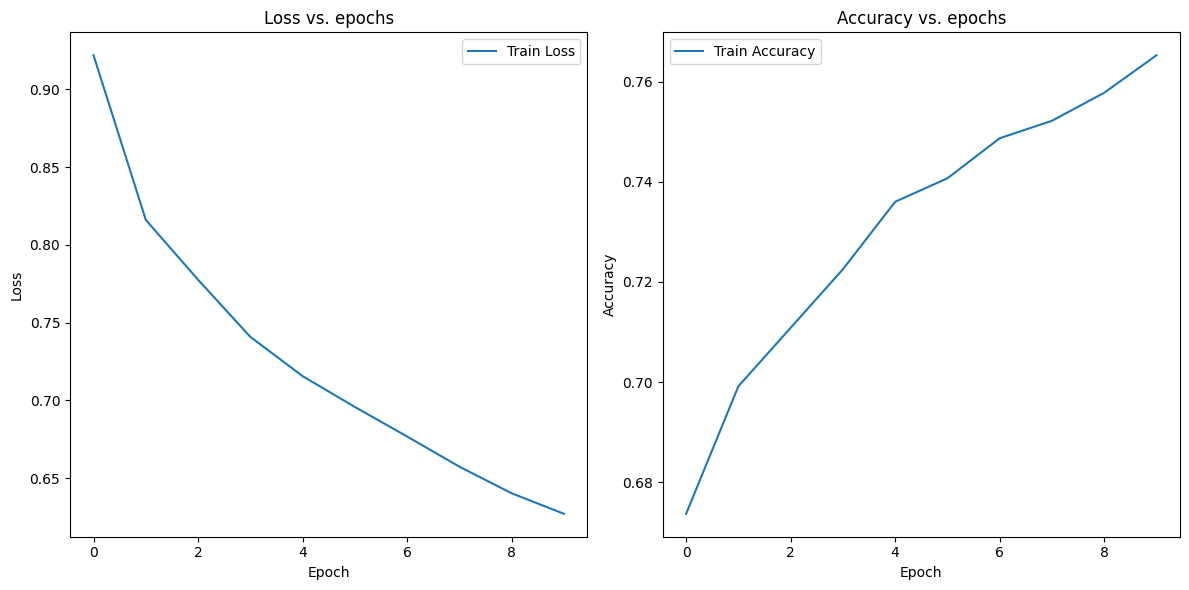

In [18]:
# Plot the loss graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
!mkdir test

In [20]:
source_dir = '/kaggle/input/isic2018-10k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/test'
destination_dir = '/kaggle/working/test/'


files = os.listdir(source_dir)
for file_name in files:
  source_path = os.path.join(source_dir, file_name)
  destination_path = os.path.join(destination_dir, file_name)
  if not os.path.exists(destination_path):
      shutil.copyfile(source_path, destination_path)

In [21]:
test_dir = '/kaggle/working/test'

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="image",
    y_col=test_df.columns[1:],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw')

predictions = model_without_dilation.predict(test_generator)

Found 1512 validated image filenames.
48/48 [==============================] - 4s 68ms/step


In [32]:

# Assuming that the labels are one-hot encoded, we need to get the index of the maximum value for each prediction and each true label
y_pred = np.argmax(predictions, axis=1)
y_true = test_df.iloc[:, 1:].values.argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=test_df.columns[1:]))

report_without_dilation = classification_report(y_true, y_pred, target_names=test_df.columns[1:], output_dict=True)

df_without_dilation = pd.DataFrame(report_without_dilation).transpose()


              precision    recall  f1-score   support

         MEL       0.00      0.00      0.00       171
          NV       0.61      0.32      0.42       909
         BCC       0.04      0.03      0.04        93
       AKIEC       0.00      0.00      0.00        43
         BKL       0.15      0.65      0.24       217
          DF       0.00      0.00      0.00        44
        VASC       0.33      0.03      0.05        35

    accuracy                           0.29      1512
   macro avg       0.16      0.15      0.11      1512
weighted avg       0.40      0.29      0.29      1512



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

In [24]:
model_with_dilation = ResNet18_With_Dilation(inputShape=(224, 224, 3), num_classes=num_classes)

# Add regularization to all layers
for layer in model_with_dilation.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = regularizers.l2(0.01)

model_with_dilation.summary()

Model: "resnet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 112, 112, 64)         9472      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_21 (Ba  (None, 112, 112, 64)         256       ['conv2d_21[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_25 (Activation)  (None, 112, 112, 64)         0         ['batch_normalization_2

In [25]:
model_with_dilation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model_with_dilation.fit(train_generator, epochs=10)

Epoch 1/10
313/313 [==============================] - 322s 858ms/step - loss: 0.9310 - accuracy: 0.6667
Epoch 2/10
313/313 [==============================] - 228s 729ms/step - loss: 0.8284 - accuracy: 0.6967
Epoch 3/10
313/313 [==============================] - 228s 727ms/step - loss: 0.7869 - accuracy: 0.7068
Epoch 4/10
313/313 [==============================] - 228s 728ms/step - loss: 0.7602 - accuracy: 0.7188
Epoch 5/10
313/313 [==============================] - 228s 727ms/step - loss: 0.7467 - accuracy: 0.7256
Epoch 6/10
313/313 [==============================] - 228s 727ms/step - loss: 0.7231 - accuracy: 0.7347
Epoch 7/10
313/313 [==============================] - 228s 727ms/step - loss: 0.7008 - accuracy: 0.7389
Epoch 8/10
313/313 [==============================] - 228s 727ms/step - loss: 0.6975 - accuracy: 0.7404
Epoch 9/10
313/313 [==============================] - 228s 727ms/step - loss: 0.6833 - accuracy: 0.7446
Epoch 10/10
313/313 [==============================] - 228s 727m

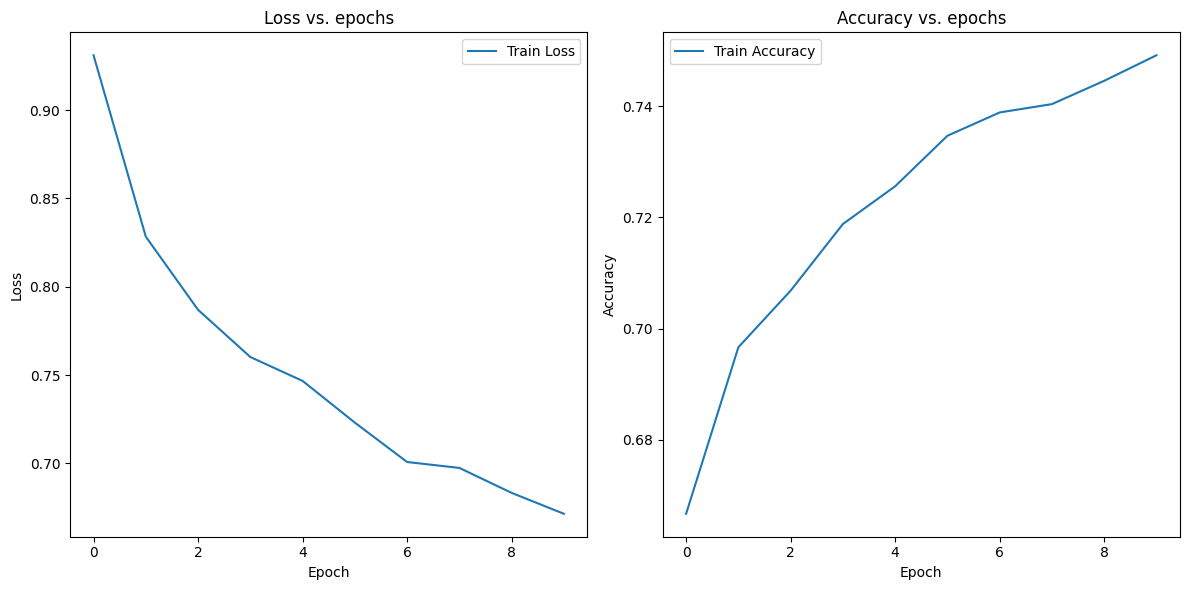

In [26]:
# Plot the loss graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
predictions2 = model_with_dilation.predict(test_generator)

48/48 [==============================] - 17s 342ms/step


In [33]:
# Assuming that the labels are one-hot encoded, we need to get the index of the maximum value for each prediction and each true label
y_pred = np.argmax(predictions2, axis=1)
y_true = test_df.iloc[:, 1:].values.argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=test_df.columns[1:]))

report_with_dilation = classification_report(y_true, y_pred, target_names=test_df.columns[1:], output_dict=True)

df_with_dilation = pd.DataFrame(report_with_dilation).transpose()

              precision    recall  f1-score   support

         MEL       0.11      0.13      0.12       171
          NV       0.60      0.70      0.65       909
         BCC       0.04      0.02      0.03        93
       AKIEC       0.00      0.00      0.00        43
         BKL       0.12      0.06      0.08       217
          DF       0.00      0.00      0.00        44
        VASC       0.03      0.06      0.04        35

    accuracy                           0.45      1512
   macro avg       0.13      0.14      0.13      1512
weighted avg       0.39      0.45      0.42      1512



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

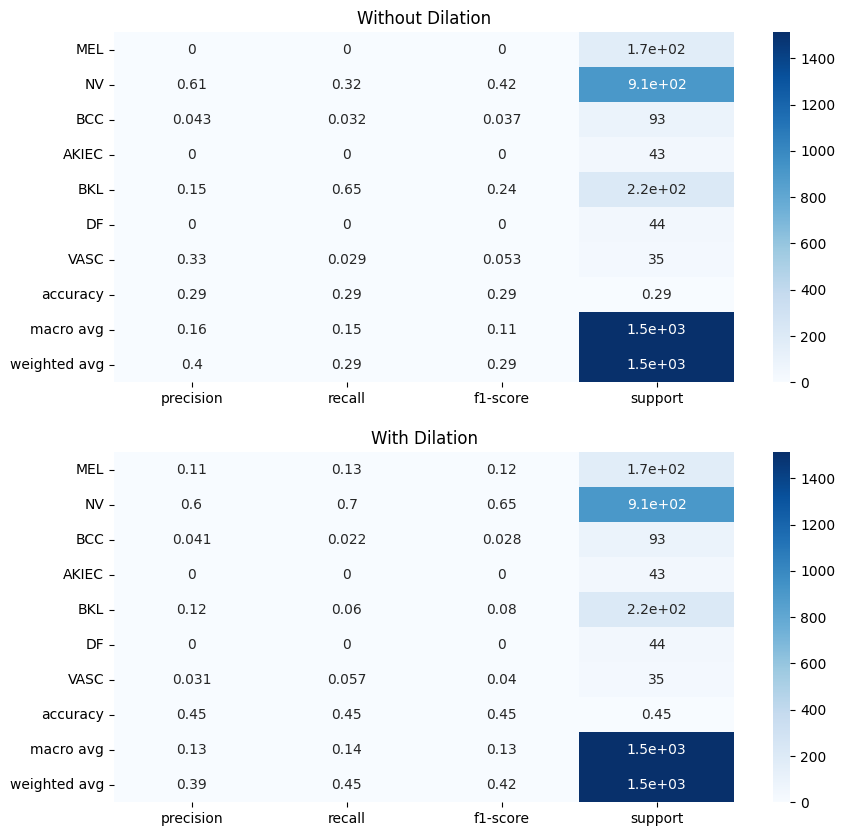

In [37]:
df_without_dilation = pd.DataFrame(report_without_dilation).transpose()
df_with_dilation = pd.DataFrame(report_with_dilation).transpose()

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
sns.heatmap(df_without_dilation, annot=True, cmap='Blues')
plt.title('Without Dilation')

plt.subplot(2, 1, 2)
sns.heatmap(df_with_dilation, annot=True, cmap='Blues')
plt.title('With Dilation')

plt.show()

### Compare both the Model with and without Dilation results

In [38]:
print("Classification report for model without dilation:")
display(df_without_dilation)

print("Classification report for model with dilation:")
display(df_with_dilation)

Classification report for model without dilation:


,precision,recall,f1-score,support
MEL,0.000000,0.000000,0.000000,171.00000
NV,0.608787,0.320132,0.419611,909.00000
BCC,0.043478,0.032258,0.037037,93.00000
AKIEC,0.000000,0.000000,0.000000,43.00000
BKL,0.148891,0.649770,0.242268,217.00000
DF,0.000000,0.000000,0.000000,44.00000
VASC,0.333333,0.028571,0.052632,35.00000
accuracy,0.288360,0.288360,0.288360,0.28836
macro avg,0.162070,0.147247,0.107364,1512.00000
weighted avg,0.397756,0.288360,0.290532,1512.00000


Classification report for model with dilation:


,precision,recall,f1-score,support
MEL,0.107317,0.128655,0.117021,171.000000
NV,0.597015,0.704070,0.646138,909.000000
BCC,0.040816,0.021505,0.028169,93.000000
AKIEC,0.000000,0.000000,0.000000,43.000000
BKL,0.122642,0.059908,0.080495,217.000000
DF,0.000000,0.000000,0.000000,44.000000
VASC,0.030769,0.057143,0.040000,35.000000
accuracy,0.449074,0.449074,0.449074,0.449074
macro avg,0.128366,0.138754,0.130261,1512.000000
weighted avg,0.391881,0.449074,0.415898,1512.000000


### Observations:
- The model with dilation has a better accuracy than the model without dilation.
- The model with dilation has a better precision than the model without dilation.
- The model with dilation has a better recall than the model without dilation.